### Objective
Here we present an alternative of Q learning: polycy gradient algorithm

# Policy gradient
In policy gradient, we parametrize directly the policy $\pi_\theta$. It's especially welcome when the action space is continuous; in that case greedy policy based on Q-learning need to compute the $argmax_a Q(s,a)$. This could be pretty tedious. More generally, policy gradient algorithms are better to explore large state-action spaces.

$J(\theta) 
= \sum_{s \in \mathcal{S}} d^\pi(s) V^\pi(s) 
= \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} \pi_\theta(a \vert s) Q^\pi(s, a)$

In discrete action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow [0,1]^{dim(A)}$ and $\forall s$ $\sum \pi_\theta(s) = 1$.

In continous action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow \mu^{dim(A)} \times \sigma^{dim(A)} =  \mathbb{R}^{dim(A)} \times \mathbb{R}_{+,*}^{dim(A)}$



It is possible to show that the loss for discrete action ($1,...,N$) with softmax policy is weighted negative binary crossentropy:
$-G\sum_{j=1}^N[a^j\log(\hat{a}^j) + (1-a^j)\log(1 - \hat{a}^j)]$

with:
$a^j=1$ if $a_t = j$, $0$ otherwise.

$\hat{a}^j = \pi_\theta(s_t)^j$.

$G$ is the discounted empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$ from state $s_t$ and $a_t$


It is possible to show that the loss for conitnous action ($1,...,N$) with multivariate Gaussian (identity Covariance) policy is given by:

$-G\sum_{j=1}^N[(a^j - \hat{a}^j)^2]$

$\hat{a}^j = \pi_\theta(s_t)^j$.



see https://aleksispi.github.io/assets/pg_autodiff.pdf for more explanation

# Reinforce - discrete action

In [2]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
from rl_introduction.tools import discount_cumsum, run_experiment_episode_train, DeepAgent
import tensorflow.keras.backend as K
import tensorflow as tf

In [1]:
#TODO: write custom loss for policy gradient
def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = None #to complete
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [ ]:
#Done: write custom loss for policy gradient
def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = K.sum(one_hot_action * K.log(action_probs) + (1 - one_hot_action) * K.log(1 - action_probs), axis=1)
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [24]:
def build_model(state_sim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
    x = Dense(32, activation='relu')(input_state)
    x = Dense(32, activation='relu')(x)
    x = Dense(action_dim, activation='softmax')(x)
    model = Model(inputs=input_state, outputs=x)
    return model

In [2]:
#TODO: complete training of vanilla policy gradient
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01):
        super().__init__(env,gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.episode = []

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            pass # complete here

    def save_model(self, path):
        self.model.save(path)

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/raphael/rl_introduction/venv/lib/python3

NameError: name 'DeepAgent' is not defined

In [25]:
#Done: complete training of vanilla policy gradient
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01):
        super().__init__(env,gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.episode = []

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            states = np.vstack(episode[:,0])
            actions = np.zeros((len(episode), self.action_dim))
            actions[np.arange(len(episode)), episode[:,1].astype(int)] = 1
            loss = policy_gradient_loss(discounted_return)
            self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-3))
            self.model.train_on_batch(states,Y)
            self.episode = []

    def save_model(self, path):
        self.model.save(path)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 13.0
episode: 1 - cum reward 15.0
episode: 2 - cum reward 54.0
episode: 3 - cum reward 37.0
episode: 4 - cum reward 15.0
episode: 5 - cum reward 18.0
episode: 6 - cum reward 16.0
episode: 7 - cum reward 22.0
episode: 8 - cum reward

episode: 240 - cum reward 46.0
episode: 241 - cum reward 38.0
episode: 242 - cum reward 11.0
episode: 243 - cum reward 19.0
episode: 244 - cum reward 32.0
episode: 245 - cum reward 33.0
episode: 246 - cum reward 30.0
episode: 247 - cum reward 18.0
episode: 248 - cum reward 49.0
episode: 249 - cum reward 20.0
episode: 250 - cum reward 38.0
episode: 251 - cum reward 19.0
episode: 252 - cum reward 23.0
episode: 253 - cum reward 50.0
episode: 254 - cum reward 36.0
episode: 255 - cum reward 54.0
episode: 256 - cum reward 25.0
episode: 257 - cum reward 45.0
episode: 258 - cum reward 43.0
episode: 259 - cum reward 34.0
episode: 260 - cum reward 51.0
episode: 261 - cum reward 46.0
episode: 262 - cum reward 37.0
episode: 263 - cum reward 28.0
episode: 264 - cum reward 23.0
episode: 265 - cum reward 39.0
episode: 266 - cum reward 19.0
episode: 267 - cum reward 31.0
episode: 268 - cum reward 18.0
episode: 269 - cum reward 56.0
episode: 270 - cum reward 20.0
episode: 271 - cum reward 41.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

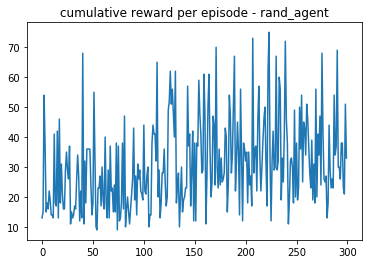

In [26]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)
q_agent = ReinforceAgent(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

# Reinforce with memory - discrete action

In [29]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgentWithMemory(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01, memory_size = 3):
        super().__init__(env,  gamma, epsilon)
        
        self.model = compiled_model
        
        self.model.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        
    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.zeros((len(episode), self.action_dim))
            Y[np.arange(len(episode)), episode[:,1].astype(int)] = 1
            if len(self.episodes) == self.memory_size:
                Xs = np.vstack([ep[0] for ep in self.episodes])
                Ys = np.vstack([ep[1] for ep in self.episodes])
                discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                discounted_returns -= discounted_returns.mean()
                discounted_returns /= discounted_returns.std()
                self.episodes = []
                loss = policy_gradient_loss(discounted_returns)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
            else:
                self.episodes.append([X,Y,discounted_return])

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_32 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 29.0
episode: 1 - cum reward 12.0
episode: 2 - cum reward 28.0
episode: 3 - cum reward 14.0
episode: 4 - cum reward 15.0
episode: 5 - cum reward 18.0
episode: 6 - cum reward 30.0
episode: 7 - cum reward 31.0
episode: 8 - cum reward

episode: 235 - cum reward 114.0
episode: 236 - cum reward 175.0
episode: 237 - cum reward 181.0
episode: 238 - cum reward 162.0
episode: 239 - cum reward 156.0
episode: 240 - cum reward 178.0
episode: 241 - cum reward 176.0
episode: 242 - cum reward 114.0
episode: 243 - cum reward 152.0
episode: 244 - cum reward 200.0
episode: 245 - cum reward 200.0
episode: 246 - cum reward 200.0
episode: 247 - cum reward 200.0
episode: 248 - cum reward 200.0
episode: 249 - cum reward 200.0
episode: 250 - cum reward 200.0
episode: 251 - cum reward 200.0
episode: 252 - cum reward 122.0
episode: 253 - cum reward 182.0
episode: 254 - cum reward 132.0
episode: 255 - cum reward 185.0
episode: 256 - cum reward 165.0
episode: 257 - cum reward 200.0
episode: 258 - cum reward 200.0
episode: 259 - cum reward 181.0
episode: 260 - cum reward 200.0
episode: 261 - cum reward 200.0
episode: 262 - cum reward 200.0
episode: 263 - cum reward 200.0
episode: 264 - cum reward 200.0
episode: 265 - cum reward 200.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

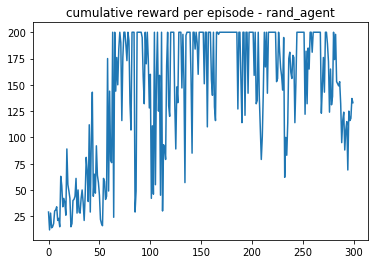

In [30]:
env = gym.make('CartPole-v0')
model = build_model(state_dim, action_dim)
q_agent = ReinforceAgentWithMemory(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

# improvment TODO complete

### actor critic

In [ ]:
    $,
    \\begin{align},
    \\nabla_\\theta J(\\theta) &= \\mathbb{E}_{\\pi_\\theta}[\\nabla_\\theta \\log \\pi_\\theta(s,a)G_t] \\text{REINFORCE}\\\\\n",
    \\nabla_\\theta J(\\theta) &= \\mathbb{E}_{\\pi_\\theta}[\\nabla_\\theta \\log \\pi_\\theta(s,a)V_w(s)] \\text{V actor-critic}\\\\\n",
    \\nabla_\\theta J(\\theta) &= \\mathbb{E}_{\\pi_\\theta}[\\nabla_\\theta \\log \\pi_\\theta(s,a)Q_w(s,a)] \\text{Q actor-critic}\\\\\n",
    \\nabla_\\theta J(\\theta) &= \\mathbb{E}_{\\pi_\\theta}[\\nabla_\\theta \\log \\pi_\\theta(s,a)A_w(s,a)] \\text{Advantage actor-critic}\\\\\n",
    \\end{align},
    $

# resampleing